In [1]:
import logging
import sys
import torch

sys.path.append("../lib")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

device = torch.device("cuda")

### Step 1: Loading the model

We prepared our custom Steam dataset with over 80,000 games and corresponding images for each of them. We can read this dataset from the `data` directory.

In [2]:
import msgspec
from steam_model import SteamGame
from pathlib import Path

data_root = Path("./data/steam")
steam_games = data_root / "games.json"

games = msgspec.json.decode(steam_games.read_text(), type=list[SteamGame])
msgspec.to_builtins(games[0])

{'id': '553850',
 'url': 'https://store.steampowered.com/app/553850/HELLDIVERS_2/',
 'raw_name': 'HELLDIVERS_2',
 'url_type': 'app',
 'popularity_rank': 1,
 'page_information': {'type': 'game',
  'title': 'HELLDIVERS™ 2',
  'description': 'Digital Deluxe Edition Edition includes:‘DP-53\u202fSavior of the Free’ Armor Set.‘Will of the People’ Cape.‘MP-98 Knight’ Weapon.Super Citizen Status.Stratagem Hero Ship Game.‘Steeled Veterans’ Premium Warbond.',
  'price': 3999,
  'images': ['images/553850/ss_0c79f56fc7be1bd0102f2ca1c92c8f0900daf4fb.600x338.jpg',
   'images/553850/ss_33e684e9cb2517af1599f0ca2b57d65ee82c2e51.600x338.jpg',
   'images/553850/ss_8949ed7dd24a02d5ea13b08fc5c04fab400dc4bd.600x338.jpg',
   'images/553850/ss_50afbbc4d811c38fe9f64c1fc8d7eb9d9da6d24c.600x338.jpg',
   'images/553850/ss_cb276fe9f0b09683bdbc496f82b405dbe0ffa1f1.600x338.jpg',
   'images/553850/ss_d0ac3830833a68d19d4a97c70aef0fba20bf0761.600x338.jpg',
   'images/553850/ss_3b08a991443164a65f84f1bd9f1363e6c2ec4581.6

Let's define a few convenience functions to easily get an image for a given game:

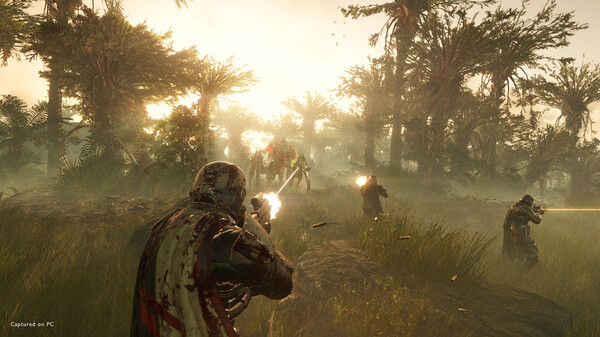

In [3]:
import PIL.Image
from PIL.Image import Image

def read_game_image(game: SteamGame, index: int) -> Image:
    return PIL.Image.open(data_root / game.page_information.images[index])

read_game_image(games[0], 0)

In [4]:
import pandas as pd

dataset = [
    { "id": game.id, "title": game.page_information.title, "image": game.page_information.images[-1], "genres": game.page_information.genres }
    for game
    in games[:1000]
]
base_df = pd.DataFrame.from_records(dataset)
one_hot_genres = base_df["genres"].str.join("|").str.get_dummies()

df = pd.concat([base_df, one_hot_genres], axis=1)
df.head()

,id,title,image,genres,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,...,Indie,Massively Multiplayer,Photo Editing,RPG,Racing,Simulation,Sports,Strategy,Utilities,Web Publishing
0,553850,HELLDIVERS™ 2,images/553850/ss_5dde7ea6922800dfece2a3a319cb6...,[Action],1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1086940,Baldur's Gate 3,images/1086940/ss_3cc4e8cfcfb8a91d19d96f631f07...,"[Adventure, RPG, Strategy]",0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1172470,Apex Legends™,images/1172470/ss_6812fedeafc652ff34b20e0f07eb...,"[Action, Adventure, Free to Play]",1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1158310,Crusader Kings III,images/1158310/ss_ac0ea36ae1b379806728f0ec9220...,"[RPG, Simulation, Strategy]",0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
4,899770,Last Epoch,images/899770/ss_8c8166cac21b3b2b6a46e9a801133...,"[Action, Adventure, Indie, RPG]",1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [5]:
import torch

labels = df.columns[4:]
id2label = { id: label for id, label in enumerate(labels) }
label2id = { label: id for id, label in enumerate(labels) }

def get_labels_from_one_hot(one_hot: torch.Tensor) -> list[str]:
    return [id2label[id] for id in torch.nonzero(one_hot).squeeze().tolist()]

id2label

{0: 'Action',
 1: 'Adventure',
 2: 'Animation & Modeling',
 3: 'Audio Production',
 4: 'Casual',
 5: 'Design & Illustration',
 6: 'Early Access',
 7: 'Education',
 8: 'Free to Play',
 9: 'Game Development',
 10: 'Indie',
 11: 'Massively Multiplayer',
 12: 'Photo Editing',
 13: 'RPG',
 14: 'Racing',
 15: 'Simulation',
 16: 'Sports',
 17: 'Strategy',
 18: 'Utilities',
 19: 'Web Publishing'}

In [73]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_id = "facebook/dinov2-large"
# model_id = "facebook/dinov2-large-imagenet1k-1-layer"

image_processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForImageClassification.from_pretrained(
    model_id,
    problem_type="multi_label_classification",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model.to(device)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-large-imagenet1k-1-layer and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([20, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-23): 24 x Dinov2Layer(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=Fals

In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

class MultiLabelDataset(Dataset):
    def __init__(self, root: Path, df: pd.DataFrame, transform: Compose):
        self.root = root
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        item = self.df.iloc[idx]

        # First, get the image
        image_path = self.root / item["image"]
        image = PIL.Image.open(image_path).convert("RGB")

        # Then, prepare the image for the model
        pixel_values = self.transform(image)

        # Get the labels as a PyTorch tensor
        labels = item[4:].values.astype(np.float32)
        labels = torch.from_numpy(labels)

        return pixel_values, labels
    
    def get_raw_image(self, idx: int) -> Image:
        item = self.df.iloc[idx]
        image_path = self.root / item["image"]
        return PIL.Image.open(image_path).convert("RGB")

BitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}

torch.Size([3, 256, 256]) ['Indie', 'Strategy']


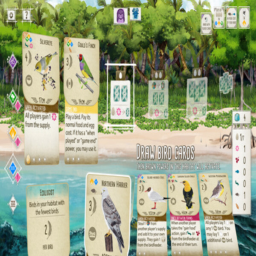

In [8]:
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

print(image_processor)
size = image_processor.size["shortest_edge"]
mean = image_processor.image_mean
std = image_processor.image_std

transform = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=mean, std=std),
])

# Split our data into training and validation sets
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42)

# Create and verify that the dataset works as we expect
train_dataset = MultiLabelDataset(root=data_root, df=train_df, transform=transform)
eval_dataset = MultiLabelDataset(root=data_root, df=eval_df, transform=transform)

pixel_values, labels = train_dataset[1]
print(pixel_values.shape, get_labels_from_one_hot(labels))

# Denormalize the pixel values to see that the image is also correctly loaded
unnormalized_image = (pixel_values.numpy() * np.array(std)[:, None, None]) + np.array(mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
PIL.Image.fromarray(unnormalized_image)

In [9]:
from transformers import TrainingArguments, Trainer, EvalPrediction
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

Batch = dict[str, torch.Tensor]

def data_collator(batch: list[tuple[torch.Tensor, torch.Tensor]]) -> Batch:
    pixel_values = torch.stack([item[0] for item in batch])
    labels = torch.stack([item[1] for item in batch])
    return { "pixel_values": pixel_values, "labels": labels }

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1

    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)

    return {'f1': f1_micro_average, 'roc_auc': roc_auc, 'accuracy': accuracy}

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result

training_args = TrainingArguments(
    output_dir="steam_genre_classifier",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    tf32=True,
    bf16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)


In [10]:
trainer.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.8221, 'grad_norm': 12.251509666442871, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.1}
{'loss': 0.6501, 'grad_norm': 8.818743705749512, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.2}
{'loss': 0.4419, 'grad_norm': 5.753881454467773, 'learning_rate': 3e-06, 'epoch': 0.3}
{'loss': 0.3098, 'grad_norm': 9.793231010437012, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.4}
{'loss': 0.3218, 'grad_norm': 4.213844299316406, 'learning_rate': 5e-06, 'epoch': 0.5}
{'loss': 0.3124, 'grad_norm': 4.831933498382568, 'learning_rate': 6e-06, 'epoch': 0.6}
{'loss': 0.2613, 'grad_norm': 7.03643798828125, 'learning_rate': 7e-06, 'epoch': 0.7}
{'loss': 0.2754, 'grad_norm': 7.082344055175781, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.8}
{'loss': 0.2704, 'grad_norm': 5.1071624755859375, 'learning_rate': 9e-06, 'epoch': 0.9}
{'loss': 0.2585, 'grad_norm': 7.12819242477417, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.28416597843170166, 'eval_f1': 0.4052757793764988, 'eval_roc_auc': 0.6381192123083753, 'eval_accuracy': 0.105, 'eval_runtime': 3.082, 'eval_samples_per_second': 64.892, 'eval_steps_per_second': 32.446, 'epoch': 1.0}
{'loss': 0.2379, 'grad_norm': 3.831773519515991, 'learning_rate': 9.88888888888889e-06, 'epoch': 1.1}
{'loss': 0.2124, 'grad_norm': 5.946229457855225, 'learning_rate': 9.777777777777779e-06, 'epoch': 1.2}
{'loss': 0.237, 'grad_norm': 4.523692607879639, 'learning_rate': 9.666666666666667e-06, 'epoch': 1.3}
{'loss': 0.2186, 'grad_norm': 5.769041061401367, 'learning_rate': 9.555555555555556e-06, 'epoch': 1.4}
{'loss': 0.224, 'grad_norm': 4.7820210456848145, 'learning_rate': 9.444444444444445e-06, 'epoch': 1.5}
{'loss': 0.2364, 'grad_norm': 8.527509689331055, 'learning_rate': 9.333333333333334e-06, 'epoch': 1.6}
{'loss': 0.2201, 'grad_norm': 15.4074125289917, 'learning_rate': 9.222222222222224e-06, 'epoch': 1.7}
{'loss': 0.2126, 'grad_norm': 43.71889114379883, 'l

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.26828619837760925, 'eval_f1': 0.4764044943820225, 'eval_roc_auc': 0.6759074097392217, 'eval_accuracy': 0.125, 'eval_runtime': 2.9585, 'eval_samples_per_second': 67.602, 'eval_steps_per_second': 33.801, 'epoch': 2.0}
{'loss': 0.1334, 'grad_norm': 23.38423728942871, 'learning_rate': 8.777777777777778e-06, 'epoch': 2.1}
{'loss': 0.1548, 'grad_norm': 4.886214256286621, 'learning_rate': 8.666666666666668e-06, 'epoch': 2.2}
{'loss': 0.154, 'grad_norm': 4.845386028289795, 'learning_rate': 8.555555555555556e-06, 'epoch': 2.3}
{'loss': 0.1451, 'grad_norm': 10.67699909210205, 'learning_rate': 8.444444444444446e-06, 'epoch': 2.4}
{'loss': 0.1457, 'grad_norm': 8.101946830749512, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}
{'loss': 0.1383, 'grad_norm': 34.83920669555664, 'learning_rate': 8.222222222222222e-06, 'epoch': 2.6}
{'loss': 0.1471, 'grad_norm': 4.689917087554932, 'learning_rate': 8.111111111111112e-06, 'epoch': 2.7}
{'loss': 0.1407, 'grad_norm': 6.214810848236084,

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.26446816325187683, 'eval_f1': 0.5153508771929824, 'eval_roc_auc': 0.6972697141661989, 'eval_accuracy': 0.13, 'eval_runtime': 3.0607, 'eval_samples_per_second': 65.344, 'eval_steps_per_second': 32.672, 'epoch': 3.0}
{'loss': 0.0822, 'grad_norm': 12.858929634094238, 'learning_rate': 7.666666666666667e-06, 'epoch': 3.1}
{'loss': 0.0793, 'grad_norm': 6.639861106872559, 'learning_rate': 7.555555555555556e-06, 'epoch': 3.2}
{'loss': 0.0727, 'grad_norm': 5.183167457580566, 'learning_rate': 7.444444444444445e-06, 'epoch': 3.3}
{'loss': 0.0896, 'grad_norm': 12.753948211669922, 'learning_rate': 7.333333333333333e-06, 'epoch': 3.4}
{'loss': 0.0942, 'grad_norm': 4.884757995605469, 'learning_rate': 7.222222222222223e-06, 'epoch': 3.5}
{'loss': 0.0866, 'grad_norm': 6.197027206420898, 'learning_rate': 7.111111111111112e-06, 'epoch': 3.6}
{'loss': 0.0838, 'grad_norm': 5.801787853240967, 'learning_rate': 7e-06, 'epoch': 3.7}
{'loss': 0.0641, 'grad_norm': 6.632780075073242, 'learning_rat

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.2692303955554962, 'eval_f1': 0.5312169312169313, 'eval_roc_auc': 0.709571793520133, 'eval_accuracy': 0.13, 'eval_runtime': 3.0857, 'eval_samples_per_second': 64.814, 'eval_steps_per_second': 32.407, 'epoch': 4.0}
{'loss': 0.0405, 'grad_norm': 3.5365684032440186, 'learning_rate': 6.555555555555556e-06, 'epoch': 4.1}
{'loss': 0.0422, 'grad_norm': 3.4179673194885254, 'learning_rate': 6.444444444444445e-06, 'epoch': 4.2}
{'loss': 0.0445, 'grad_norm': 1.980131983757019, 'learning_rate': 6.333333333333333e-06, 'epoch': 4.3}
{'loss': 0.0413, 'grad_norm': 3.066110849380493, 'learning_rate': 6.222222222222223e-06, 'epoch': 4.4}
{'loss': 0.041, 'grad_norm': 3.6384403705596924, 'learning_rate': 6.111111111111112e-06, 'epoch': 4.5}
{'loss': 0.0413, 'grad_norm': 2.236680030822754, 'learning_rate': 6e-06, 'epoch': 4.6}
{'loss': 0.0467, 'grad_norm': 3.9164435863494873, 'learning_rate': 5.88888888888889e-06, 'epoch': 4.7}
{'loss': 0.0388, 'grad_norm': 2.332228899002075, 'learning_rate'

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.29139992594718933, 'eval_f1': 0.544290288153682, 'eval_roc_auc': 0.7149969374187668, 'eval_accuracy': 0.17, 'eval_runtime': 3.0764, 'eval_samples_per_second': 65.011, 'eval_steps_per_second': 32.505, 'epoch': 5.0}
{'loss': 0.0207, 'grad_norm': 2.4925694465637207, 'learning_rate': 5.444444444444445e-06, 'epoch': 5.1}
{'loss': 0.0208, 'grad_norm': 1.631845235824585, 'learning_rate': 5.333333333333334e-06, 'epoch': 5.2}
{'loss': 0.025, 'grad_norm': 2.295987129211426, 'learning_rate': 5.2222222222222226e-06, 'epoch': 5.3}
{'loss': 0.0174, 'grad_norm': 0.928215742111206, 'learning_rate': 5.1111111111111115e-06, 'epoch': 5.4}
{'loss': 0.0247, 'grad_norm': 1.012333631515503, 'learning_rate': 5e-06, 'epoch': 5.5}
{'loss': 0.0237, 'grad_norm': 2.870105504989624, 'learning_rate': 4.888888888888889e-06, 'epoch': 5.6}
{'loss': 0.023, 'grad_norm': 7.463061332702637, 'learning_rate': 4.777777777777778e-06, 'epoch': 5.7}
{'loss': 0.021, 'grad_norm': 1.8616098165512085, 'learning_rate'

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.3125442564487457, 'eval_f1': 0.5289617486338798, 'eval_roc_auc': 0.7043056477412662, 'eval_accuracy': 0.145, 'eval_runtime': 3.0613, 'eval_samples_per_second': 65.332, 'eval_steps_per_second': 32.666, 'epoch': 6.0}
{'loss': 0.0095, 'grad_norm': 2.746340751647949, 'learning_rate': 4.333333333333334e-06, 'epoch': 6.1}
{'loss': 0.0096, 'grad_norm': 0.7886263728141785, 'learning_rate': 4.222222222222223e-06, 'epoch': 6.2}
{'loss': 0.0109, 'grad_norm': 1.246182918548584, 'learning_rate': 4.111111111111111e-06, 'epoch': 6.3}
{'loss': 0.0126, 'grad_norm': 1.0790411233901978, 'learning_rate': 4.000000000000001e-06, 'epoch': 6.4}
{'loss': 0.0142, 'grad_norm': 9.845702171325684, 'learning_rate': 3.88888888888889e-06, 'epoch': 6.5}
{'loss': 0.0123, 'grad_norm': 3.2745108604431152, 'learning_rate': 3.777777777777778e-06, 'epoch': 6.6}
{'loss': 0.0114, 'grad_norm': 0.4983232319355011, 'learning_rate': 3.6666666666666666e-06, 'epoch': 6.7}
{'loss': 0.0114, 'grad_norm': 1.295336842536

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.32919666171073914, 'eval_f1': 0.5542916235780765, 'eval_roc_auc': 0.7245314890974242, 'eval_accuracy': 0.155, 'eval_runtime': 3.0617, 'eval_samples_per_second': 65.324, 'eval_steps_per_second': 32.662, 'epoch': 7.0}
{'loss': 0.0067, 'grad_norm': 1.5851539373397827, 'learning_rate': 3.2222222222222227e-06, 'epoch': 7.1}
{'loss': 0.0053, 'grad_norm': 0.4350639283657074, 'learning_rate': 3.1111111111111116e-06, 'epoch': 7.2}
{'loss': 0.0073, 'grad_norm': 0.581185519695282, 'learning_rate': 3e-06, 'epoch': 7.3}
{'loss': 0.0056, 'grad_norm': 0.47978687286376953, 'learning_rate': 2.888888888888889e-06, 'epoch': 7.4}
{'loss': 0.0072, 'grad_norm': 0.31200292706489563, 'learning_rate': 2.7777777777777783e-06, 'epoch': 7.5}
{'loss': 0.0061, 'grad_norm': 0.7084271907806396, 'learning_rate': 2.666666666666667e-06, 'epoch': 7.6}
{'loss': 0.0048, 'grad_norm': 0.71182781457901, 'learning_rate': 2.5555555555555557e-06, 'epoch': 7.7}
{'loss': 0.005, 'grad_norm': 0.3157733082771301, 'lea

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.3409709930419922, 'eval_f1': 0.5415318230852212, 'eval_roc_auc': 0.7121744540175303, 'eval_accuracy': 0.155, 'eval_runtime': 3.0908, 'eval_samples_per_second': 64.707, 'eval_steps_per_second': 32.354, 'epoch': 8.0}
{'loss': 0.0035, 'grad_norm': 0.506030797958374, 'learning_rate': 2.1111111111111114e-06, 'epoch': 8.1}
{'loss': 0.0033, 'grad_norm': 0.15501782298088074, 'learning_rate': 2.0000000000000003e-06, 'epoch': 8.2}
{'loss': 0.0037, 'grad_norm': 0.135964497923851, 'learning_rate': 1.888888888888889e-06, 'epoch': 8.3}
{'loss': 0.0048, 'grad_norm': 0.33508095145225525, 'learning_rate': 1.777777777777778e-06, 'epoch': 8.4}
{'loss': 0.0027, 'grad_norm': 0.1624964475631714, 'learning_rate': 1.6666666666666667e-06, 'epoch': 8.5}
{'loss': 0.0035, 'grad_norm': 0.18894097208976746, 'learning_rate': 1.5555555555555558e-06, 'epoch': 8.6}
{'loss': 0.0027, 'grad_norm': 0.11190564185380936, 'learning_rate': 1.4444444444444445e-06, 'epoch': 8.7}
{'loss': 0.0036, 'grad_norm': 0.23

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.3640841543674469, 'eval_f1': 0.5391304347826087, 'eval_roc_auc': 0.7099852953416751, 'eval_accuracy': 0.155, 'eval_runtime': 3.0601, 'eval_samples_per_second': 65.356, 'eval_steps_per_second': 32.678, 'epoch': 9.0}
{'loss': 0.0026, 'grad_norm': 2.320949077606201, 'learning_rate': 1.0000000000000002e-06, 'epoch': 9.1}
{'loss': 0.0023, 'grad_norm': 0.1290062963962555, 'learning_rate': 8.88888888888889e-07, 'epoch': 9.2}
{'loss': 0.0024, 'grad_norm': 0.15462534129619598, 'learning_rate': 7.777777777777779e-07, 'epoch': 9.3}
{'loss': 0.003, 'grad_norm': 0.2815929651260376, 'learning_rate': 6.666666666666667e-07, 'epoch': 9.4}
{'loss': 0.0023, 'grad_norm': 0.11360690742731094, 'learning_rate': 5.555555555555555e-07, 'epoch': 9.5}
{'loss': 0.0022, 'grad_norm': 0.14079450070858002, 'learning_rate': 4.444444444444445e-07, 'epoch': 9.6}
{'loss': 0.0027, 'grad_norm': 0.1392434984445572, 'learning_rate': 3.3333333333333335e-07, 'epoch': 9.7}
{'loss': 0.0027, 'grad_norm': 0.1635646

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 0.36720535159111023, 'eval_f1': 0.5430752453653217, 'eval_roc_auc': 0.711486173566189, 'eval_accuracy': 0.16, 'eval_runtime': 3.0777, 'eval_samples_per_second': 64.984, 'eval_steps_per_second': 32.492, 'epoch': 10.0}
{'train_runtime': 465.257, 'train_samples_per_second': 17.195, 'train_steps_per_second': 2.149, 'train_loss': 0.09307798551395535, 'epoch': 10.0}


TrainOutput(global_step=1000, training_loss=0.09307798551395535, metrics={'train_runtime': 465.257, 'train_samples_per_second': 17.195, 'train_steps_per_second': 2.149, 'train_loss': 0.09307798551395535, 'epoch': 10.0})

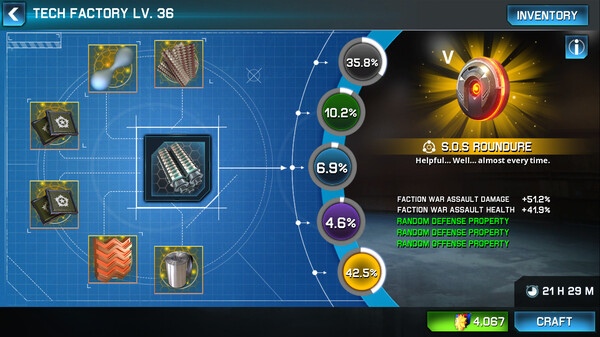

In [70]:
# inferred_index = 50
# inferred_index = 80
# inferred_index = 140
# inferred_index = 150
# inferred_index = 170

img = eval_dataset.get_raw_image(inferred_index)
img

In [71]:
from transformers import pipeline

classifier = pipeline("image-classification", model="./steam_genre_classifier/with-tf32")
classifier(img)

[{'label': 'Strategy', 'score': 0.9626442193984985},
 {'label': 'Indie', 'score': 0.6870889067649841},
 {'label': 'Action', 'score': 0.4327949285507202},
 {'label': 'Simulation', 'score': 0.3695979416370392},
 {'label': 'Casual', 'score': 0.0565204955637455}]